# Отток клиентов

##### Описание проекта

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.


Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Были предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.


Необходимо построить модель с предельно большим значением F1-меры. 

## Загрузка и предобработка данных

In [99]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler 

In [100]:
try:
    df = pd.read_csv('C:/Users/trombee/Desktop/Учеба/ЯП. Обучение с учителем. Проект/Churn.csv')
except:
    df = pd.read_csv('/datasets/Churn.csv')

In [101]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [103]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [104]:
df.loc[df['Tenure'].isna(), 'Tenure'] = df['Tenure'].median()

In [105]:
df['Tenure'].isna().sum()

0

Так как столбец "Tenure" практически никак не коррелирует с фактом ухода клиента, было решено совсем не использовать этот столбец в анализе.

In [106]:
df = df.drop(['Surname', 'RowNumber', 'CustomerId'], axis=1)

In [107]:
df = pd.get_dummies(df, drop_first=True)

In [108]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Был проанализирован предоставленный датасет. В данных присутствует дисбаланс классов. Так как количество 1 в столбце "Exited" равно всего 20%, это следует учесть при обучении модели. Также в столбце "Tenure" имеются пропуски в количестве почти 10% от всех данных. Просто удалить строки с пропусками в этом столбце было бы некорректно, так как достаточно большой объем. Поэтому сделал проверку на корреляцию этого признака с целевым признаком, и оказалось, что он совсем никак не влияет на результат. Исходя из этого, данный столбец было решено совсем удалить и не использовать далее. То же самое с фамилиями клиентов, в дальнейшем анализе он не участвовал.

## Разбивка на выборки и обучение моделей без учета дисбаланса классов

In [109]:
features = df.drop('Exited', axis=1)
target = df['Exited']
features_train, features_valid, target_train, target_valid = train_test_split(features,
                                                                              target,
                                                                              test_size=0.3,
                                                                              random_state=12345,
                                                                              stratify=target)

In [110]:
features_valid, features_test, target_valid, target_test = train_test_split(features_valid,
                                                                            target_valid,
                                                                            test_size=0.5,
                                                                            random_state=12345,
                                                                            stratify=target_valid)

In [112]:
#ohe = OneHotEncoder()
#features_train = ohe.fit_transform(features_train)
#features_train

Данные были разбиты на выборки в отношении 70%-15%-15% (train-valid-test).

In [113]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(7000, 11)
(1500, 11)
(1500, 11)


In [114]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)
features_test = scaler.transform(features_test)

In [115]:
%%time

model_log_disbalanced = LogisticRegression(random_state=12345, solver='liblinear')
model_log_disbalanced.fit(features_train, target_train)
predicted = model_log_disbalanced.predict(features_valid)
f1_log = f1_score(target_valid, predicted)
f1_log

Wall time: 19.8 ms


0.25757575757575757

In [116]:
probabilities_valid = model_log_disbalanced.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

0.7714224718363056


In [117]:
%%time

score=0
best_depth=0

for depth in range(1, 140, 10):
    model_dt_disbalanced = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_dt_disbalanced.fit(features_train, target_train)
    predicted = model_dt_disbalanced.predict(features_valid)
    f1_dt = f1_score(target_valid, predicted)
    if f1_dt > score:
        score = f1_dt
        best_depth = depth
print(score, best_depth)

0.5253164556962024 31
Wall time: 865 ms


In [118]:
probabilities_valid = model_dt_disbalanced.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

0.7042401550234834


In [119]:
%%time

score=0
best_depth=0

for depth in range(1, 140, 10):
    model_rf_disbalanced = RandomForestClassifier(random_state=12345, max_depth=depth)
    model_rf_disbalanced.fit(features_train, target_train)
    predicted = model_rf_disbalanced.predict(features_valid)
    f1_rf = f1_score(target_valid, predicted)
    if f1_rf > score:
        score = f1_rf
        best_depth = depth
print(score, best_depth)

score=0
best_est=0

for est in range(1, 140, 10):
    model_rf_disbalanced = RandomForestClassifier(random_state=12345, max_depth=best_depth, n_estimators=est)
    model_rf_disbalanced.fit(features_train, target_train)
    predicted = model_rf_disbalanced.predict(features_valid)
    f1_rf = f1_score(target_valid, predicted)
    if f1_rf > score:
        score = f1_rf
        best_est = est
print(score, best_est)

0.5743801652892562 31
0.5865580448065173 111
Wall time: 36 s


0.8589762538181103


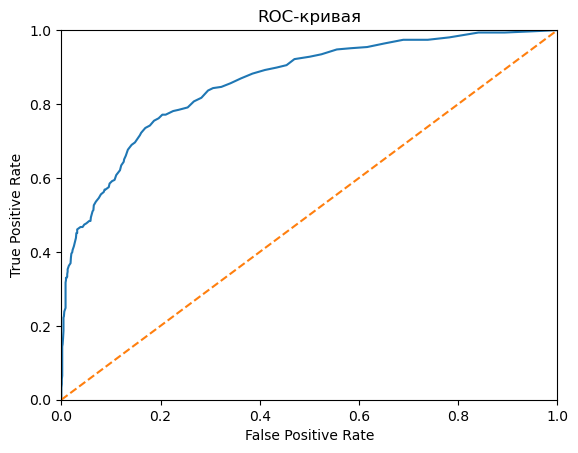

In [120]:
probabilities_valid = model_rf_disbalanced.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Максимальный результ f1-меры был получен моделью - Случайный лес, с max_depth =  31 и n_estimators = 111. И был равен 0.586. auc_roc = 0.858. Также можно отметить, что модель логистической регрессии здесь точно не подходит, так как результат у нее равен 0.25, и модель дерева решений показало себя слабее, с результатом равным 0.52

## Анализ моделей, с учетом дисбаланса классов

Далее будет провезен анализ с учетом дисбаланса классов

In [59]:
#features_train = pd.DataFrame(data=features_train, columns=df.columns.drop('Exited'))
#target_train = pd.DataFrame(data=target_train, columns=['Exited'])

### Метод class_weight='balanced'

In [74]:
#features_train = features_train.drop('index', axis=1)
#target_train = target_train.drop('index', axis=1)

#### Логистическая регрессия

In [121]:
%%time

model_log_balanced = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_log_balanced.fit(features_train, target_train)
predicted = model_log_balanced.predict(features_valid)
f1_log = f1_score(target_valid, predicted)
f1_log

Wall time: 18.1 ms


0.5063879210220673

In [122]:
probabilities_valid = model_log_balanced.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

0.7791873309904643


#### Дерево решений

In [ ]:
#подбор гиперпараметров
'''
%%time

score=0
best_depth=0

for depth in range(1, 140, 10):
    model_dt_disbalanced = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model_dt_disbalanced.fit(features_train, target_train)
    predicted = model_dt_disbalanced.predict(features_valid)
    f1_dt = f1_score(target_valid, predicted)
    if f1_dt > score:
        score = f1_dt
        best_depth = depth
print(score, best_depth)
'''

In [123]:
model_dt_balanced = DecisionTreeClassifier(random_state=12345, max_depth=11, class_weight='balanced')
model_dt_balanced.fit(features_train, target_train)
predicted = model_dt_balanced.predict(features_valid)
f1_dt = f1_score(target_valid, predicted)
f1_dt

0.5375170532060027

In [124]:
probabilities_valid = model_log_balanced.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

0.7791873309904643


#### Случайный лес

In [143]:
#подбор гиперпараметров
'''
%%time

score = 0
depth = 0
for depth in range(1, 40, 1):
    model_rf = RandomForestClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model_rf.fit(features_train, target_train)
    predict_rf = model_rf.predict(features_valid)
    f1_rf = f1_score(target_valid, predict_rf)
    if f1_rf > score:
        score = f1_rf
        best_depth = depth
        
print(score, best_depth)

score = 0
est = 0
for est in range(1, 200, 10):
    model_rf = RandomForestClassifier(random_state=12345, max_depth=best_depth, n_estimators=est, class_weight='balanced')
    model_rf.fit(features_train, target_train)
    predict_rf = model_rf.predict(features_valid)
    f1_rf = f1_score(target_valid, predict_rf)
    if f1_rf > score:
        score = f1_rf
        best_est = est
        
print(score, best_est)
'''

model_rf = RandomForestClassifier(random_state=12345, max_depth=8, n_estimators=121, class_weight='balanced')
model_rf.fit(features_train, target_train)
predict_rf = model_rf.predict(features_valid)
f1_rf = f1_score(target_valid, predict_rf)
f1_rf

0.6354319180087847

In [144]:
probabilities_valid = model_rf.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
auc_roc

0.868104137243954

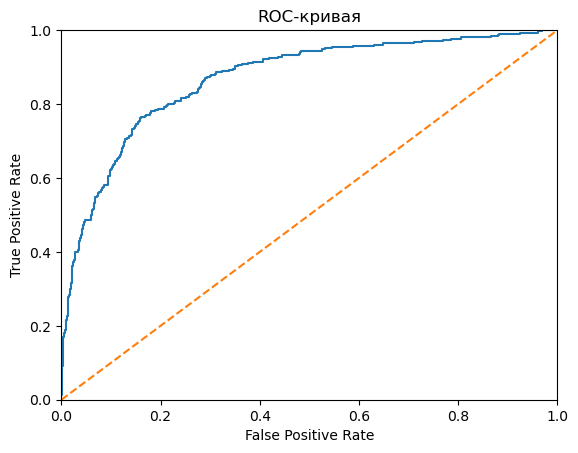

In [145]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

### Метод upsample

In [133]:
features = df.drop('Exited', axis=1)
target = df['Exited']
features_train, features_valid, target_train, target_valid = train_test_split(features,
                                                                              target,
                                                                              test_size=0.3,
                                                                              random_state=12345,
                                                                              stratify=target)

features_valid, features_test, target_valid, target_test = train_test_split(features_valid,
                                                                            target_valid,
                                                                            test_size=0.5,
                                                                            random_state=12345,
                                                                            stratify=target_valid)

In [134]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 5)

#### Логистическая регрессия

In [135]:
%%time

model_log_balanced = LogisticRegression(random_state=12345, solver='liblinear')
model_log_balanced.fit(features_upsampled, target_upsampled)
predicted = model_log_balanced.predict(features_valid)
f1_log = f1_score(target_valid, predicted)
f1_log

Wall time: 107 ms


0.44109831709477415

In [136]:
probabilities_valid = model_log_balanced.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

0.72544366713743


#### Дерево решений

In [137]:
model_dt_balanced = DecisionTreeClassifier(random_state=12345, max_depth=11)
model_dt_balanced.fit(features_upsampled, target_upsampled)
predicted = model_dt_balanced.predict(features_valid)
f1_dt = f1_score(target_valid, predicted)
f1_dt

0.553306342780027

In [138]:
probabilities_valid = model_log_balanced.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

0.72544366713743


#### Случайный лес

In [140]:
%%time
#подбор гиперпараметров


score = 0
depth = 0
for depth in range(1, 40, 1):
    model_rf = RandomForestClassifier(random_state=12345, max_depth=depth)
    model_rf.fit(features_upsampled, target_upsampled)
    predict_rf = model_rf.predict(features_valid)
    f1_rf = f1_score(target_valid, predict_rf)
    if f1_rf > score:
        score = f1_rf
        best_depth = depth
        
print(score, best_depth)

score = 0
est = 0
for est in range(1, 200, 10):
    model_rf = RandomForestClassifier(random_state=12345, max_depth=best_depth, n_estimators=est)
    model_rf.fit(features_upsampled, target_upsampled)
    predict_rf = model_rf.predict(features_valid)
    f1_rf = f1_score(target_valid, predict_rf)
    if f1_rf > score:
        score = f1_rf
        best_est = est
        
print(score, best_est)

'''
model_rf = RandomForestClassifier(random_state=12345, max_depth=8, n_estimators=121, class_weight='balanced')
model_rf.fit(features_train, target_train)
predict_rf = model_rf.predict(features_valid)
f1_rf = f1_score(target_valid, predict_rf)
f1_rf
'''

0.622286541244573 11
0.6251808972503619 101
Wall time: 2min 5s


"\nmodel_rf = RandomForestClassifier(random_state=12345, max_depth=8, n_estimators=121, class_weight='balanced')\nmodel_rf.fit(features_train, target_train)\npredict_rf = model_rf.predict(features_valid)\nf1_rf = f1_score(target_valid, predict_rf)\nf1_rf\n"

In [141]:
probabilities_valid = model_rf.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
auc_roc

0.8640479083872521

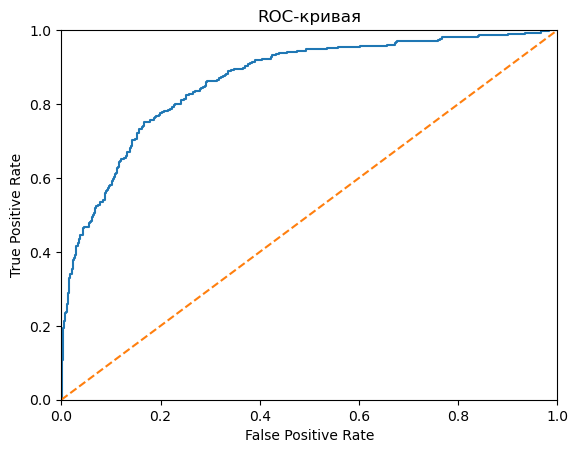

In [142]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Теперь уже дисбаланс классов был учтен. После чего результат получился гораздо лучше: f1-мера = 0.64, auc_roc = 0.866

In [146]:
features_train = pd.concat([features_train, features_valid])
target_train = pd.concat([target_train, target_valid])

## Финальное тестирование

In [147]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 5)

In [148]:
model_rf = RandomForestClassifier(random_state=12345, max_depth=8, n_estimators=121)
model_rf.fit(features_upsampled, target_upsampled)
predict_rf = model_rf.predict(features_test)
f1_rf = f1_score(target_test, predict_rf)
f1_rf

0.6355140186915887

In [149]:
probabilities_valid = model_rf.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]

In [150]:
auc_roc = roc_auc_score(target_test, probabilities_one_valid)
auc_roc

0.8736237053295836

<div style="border:solid orange 2px; padding: 20px"> 

## Вывод

Изначально были предоставлены хорошие данные, в которых были пропуски только в столбце Tenure. Этот столбец был проверен на корреляцию с целевым признаком, после чего, было принято решение удалить этот столбец из анализа, так как он практически не коррелирует с целевым признаком. Также поступил со столбцом Surname.

Далее, когда данные были подготовлены, они были разделены на выборки в соотношении 70-15-15. После чего были обучены модели логистической регрессии, дерева решений и случайного леса без учета дисбаланса. Лучшим результатом был случайный лес, где f1-мера = 0.56.

Далее был учтен дисбаланс классов и уже была взята модель только случайной леса, и также проанализирована. Лучший результат f1-меры = 0.64.

Далее выборки были еще немного доработаны\
В конечном итоге наилучшие результаты показала модель случайного леса. Лучший результат f1-меры получился равным 0.66, auc-roc = 0.869 \
Для достижения этого результата был использован метод увеличения выборки upsample, учтен дисбаланс классов (class_weight = 'balanced'), а также еще сильнее увеличена выборка за счет сложения тренировочной выборки и валидационной, после чего модель была обучена и протестирована сразу на тестовой выборке. Результат стал лучше, чем обучать только на тренировочной выборке.